#### 본 매뉴얼은 베이지안 선형회귀모형 하 변수선택에 대해 다룬다.
- 작성자: 고려대학교 경제학과 강규호 교수, 데이터사이언스팀 이창훈 과장

## 베이지안 변수선택
베이지안 변수선택은 선형회귀모형에서 중요한 변수들을 선별하는 기법이다. 이 방법은 사전확률과 데이터를 결합하여 변수의 중요도(사후포함확률)를 평가하고, 불필요한 변수를 제외시킨다. 
### 모형
* $p \sim Beta(a_{0}, c_{0})$
* $Pr[\gamma_{k}=1|p] = p, Pr[\gamma_{k}=0|p]= 1-p$, for $k=1,2,..,K$
* $b_{0} \sim IG(\frac{\alpha_{00}}{2}, \frac{\delta_{00}}{2})$
* $b_{0} \sim IG(\frac{\alpha_{01}}{2}, \frac{\delta_{01}}{2})$
* $\beta_{k}|\gamma_{k}, b_{0}, b_{1} \sim Normal(0, \gamma_{k}b_{1} + (1-\gamma_{k})b_{0})$
    * $\beta = (\beta_{1}, \beta{2}, .., \beta_{K}) $
* $\sigma^{2} \sim IG(\frac{\alpha_{0}}{2}, \frac{\delta_{0}}{2})$


### 사전분포에 대한 기본 하이퍼-파라미터
* 샘플링 크기
    * $n$: 깁스-샘플링 크기
    * $n_{0}$: 번인(burn-in) 크기
    * $n_{1}=n-n_{0}$

* $\sigma^{2}$ 하이퍼-파라미터
    * $\alpha_{0}=5$
    * $\delta_{0}=5$
    * $\mathbb{E}[\sigma^{2}] = \frac{\delta_{0}}{\alpha_{0}}$

* $p$ 하이퍼-파라미터
    * $a_{0} = 10$
    * $c_{0} = 10$
    * $\mathbb{E}[p] = \frac{c_{0}}{c_{0} + a_{0}}$

* $b_{0}$ 하이퍼-파라미터
    * $\alpha_{00} = 20$
    * $\delta_{00} = \alpha_{00} * 0.0001$
    * $\mathbb{E}[b_{0}] = \frac{\delta_{00}}{\alpha_{00}}$

* $b_{1}$ 하이퍼-파라미터
    * $\alpha_{01} = 20$
    * $\delta_{01} = \alpha_{00} * 10$
    * $\mathbb{E}[b_{1}] = \frac{\delta_{01}}{\alpha_{01}}$

### 1) 자료 불러오기

In [1]:
import pandas as pd

In [2]:
# 데이터프레임 형태로 데이터 불러오기d
df = pd.read_excel("../data/bayes_test_data.xlsx")
df.columns = ['gdp', 'gdp_l1', 'cpi', 'm2', 'kr10y', 'us10y']
df.index = pd.date_range(start='2000-Q4', end='2023-Q4', freq='Q')
df

C:\Users\BOK\AppData\Local\Temp\ipykernel_122072\4200898414.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.index = pd.date_range(start='2000-Q4', end='2023-Q4', freq='Q')


,gdp,gdp_l1,cpi,m2,kr10y,us10y
2000-12-31,-0.324985,2.717335,0.659799,1.417791,7.760,5.12
2001-03-31,1.218106,-0.324985,1.766167,1.752773,6.690,4.93
2001-06-30,1.290518,1.218106,1.157815,2.339417,7.490,5.42
2001-09-30,1.341160,1.290518,0.574675,4.178410,6.440,4.60
2001-12-31,1.747232,1.341160,-0.254330,-0.487594,6.810,5.07
...,...,...,...,...,...,...
2022-09-30,0.233454,0.747667,1.128388,0.938318,3.497,3.83
2022-12-31,-0.303428,0.233454,0.394695,0.276973,3.890,3.88
2023-03-31,0.329332,-0.303428,1.047989,0.496197,3.437,3.48
2023-06-30,0.606808,0.329332,0.641578,0.824358,3.447,3.81


In [3]:
# 종속변수와 설명변수 지정
Y = df['gdp'] # gdp
X = df.drop(columns='gdp') # gdp를 제외한 변수들

`bok_da` 라이브러리 `bayes` 패키안의 `linear_model` 서브패키지에서 `gen_hyper_para`, `bayes_linear_vs`, `get_table`, `plot_hist` 함수를 불러온다.

In [4]:
from bok_da.bayes.linear_model import gen_hyper_para, bayes_linear_vs, get_table, plot_hist

In [5]:
# 하이퍼-파라미터 생성
hyper = gen_hyper_para('VS') # 'VS' 입력, 변수선택모형에 대한 하이퍼 파라미터 생성
res = bayes_linear_vs(Y=Y, X=X, hyper=hyper)

In [6]:
res.get_table('beta')

,Mean,Median,S.E.,0.05%,0.95%
gdp_l1,0.003610,0.001207,0.026123,-0.016726,0.021114
cpi,0.038478,0.002688,0.114287,-0.015918,0.332904
m2,0.002795,0.001115,0.020200,-0.016495,0.020698
kr10y,0.007129,0.000028,0.046040,-0.019699,0.064989
us10y,0.249308,0.261154,0.070227,0.114477,0.321267


### 3) 예측분포 출력

Out-of-sample forecasting(표본 외 예측)을 원할 경우 X의 실현값(XT1)을 함께 입력하면 yf(예측 분포)가 함께 출력된다.

In [7]:
res = bayes_linear_vs(Y=Y.iloc[:-1], X=X.iloc[:-1,:], XT1=X.iloc[-1,:], hyper=hyper, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.007136  0.001292  0.040465 -0.016889  0.026900
cpi     0.053709  0.003269  0.139397 -0.016389  0.406849
m2      0.002304  0.001179  0.018429 -0.016287  0.019700
kr10y   0.001421 -0.000582  0.038152 -0.020549  0.020723
us10y   0.255157  0.263298  0.065298  0.156204  0.326555
R2: 
        Mean    Median      S.E.    0.05%     0.95%
R2  0.366759  0.365908  0.034866  0.31055  0.425725
Forecast: 
        Mean   Median      S.E.     0.05%     0.95%
yf  1.234971  1.23745  0.909382 -0.259944  2.741439


### 4) PPL(Posterior Predictive Likelihood) 함께 출력

Out-of-sample Forecasting(표본 외 예측)을 통해 튜닝을 원할 경우 아래와 같이 X, Y의 실현값(XT1, YT1)을 모두 입력하면 log PPL이 함께 계산된다.

In [8]:
hyper = gen_hyper_para('VS')
res = bayes_linear_vs(Y=Y.iloc[:-1], X=X.iloc[:-1,:], YT1=Y.iloc[[-1]], XT1=X.iloc[-1,:], hyper=hyper, print_info=True)

Coefficients: 
            Mean    Median      S.E.     0.05%     0.95%
gdp_l1  0.005509  0.001333  0.033643 -0.016782  0.023821
cpi     0.047696  0.002925  0.131327 -0.016119  0.380512
m2      0.002153  0.001037  0.018212 -0.016560  0.020023
kr10y   0.017471  0.000773  0.067414 -0.020989  0.196325
us10y   0.235858  0.260840  0.098179 -0.000577  0.328028
R2: 
        Mean    Median      S.E.     0.05%     0.95%
R2  0.366621  0.365323  0.035021  0.310366  0.425864
Forecast: 
        Mean    Median      S.E.     0.05%    0.95%
yf  1.200584  1.202267  0.906431 -0.294194  2.68941
log PPL:  -1.0416078417262895


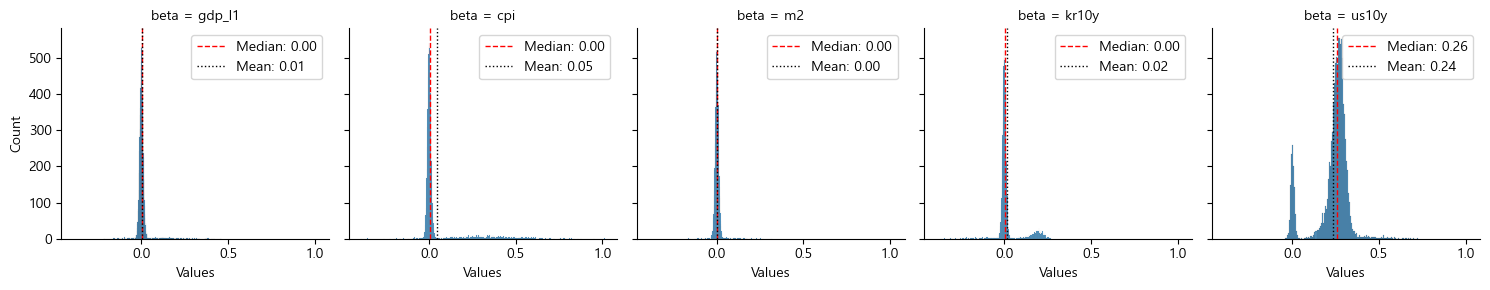

In [9]:
# 결과 히스토그램 그리기
plot_hist(res.beta, name='beta')

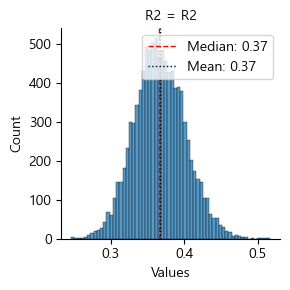

In [10]:
plot_hist(res.r2, name='R2')

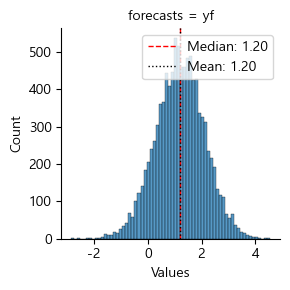

In [11]:
plot_hist(res.yf, name='forecasts')

베이지안 변수선택에서 설명변수의 중요도를 나타내는 사후포함확률(Posterior Probability Inclusion, PPI)은 res 인스턴스의 plot_ppi 메서드를 이용해 그릴 수 있다.

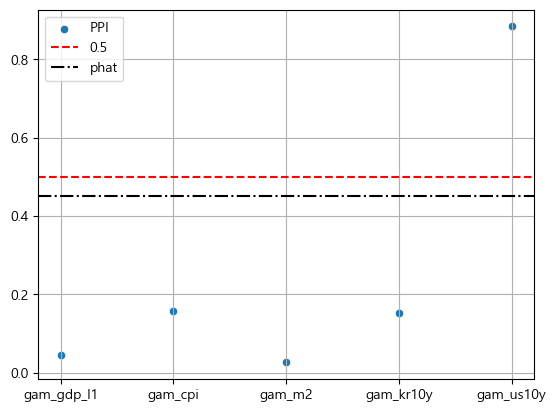

In [12]:
# 각 변수의 사후포함확률 PPI 그래프 그리기
res.plot_ppi()

## BayesVariableSelection 클래스로 모형 설정하고 추정

`bayes_linear_vs` 함수를 사용하는 방법외에 `BayesVariableSelection` 클래스를 이용한 추정 기능도 제공한다.

모형 클래스 불러오기
- `bok_da` 라이브러리 `bayes` 패키지안의 `linear_model` 서브패키지에서 `BayesVariableSelection` 클래스를 `BVS`로 불러온다.

In [13]:
from bok_da.bayes.linear_model import BayesVariableSelection as BVS

모형 설정
- BVS 클래스를 이용해 model 객체를 생성한다. 여기서 model의 특성은 hyper에 의해 결정된다.

In [14]:
#data = df.copy()
hyper = gen_hyper_para('VS') # 변수선택 모형에 대한 하이퍼 파라미터 생성
model = BVS(hyper)

모형 추정
- model 인스턴스의 fit 메서드를 이용해 추정할 수 있다.

In [15]:
res = model.fit(df)

결과 보기
- res 인스턴스의 get_table, plot_hist 등의 메서드를 이용해 결과를 출력한다.

In [16]:
res.get_table('beta')

,Mean,Median,S.E.,0.05%,0.95%
gdp_l1,0.004928,0.001277,0.029930,-0.016095,0.022958
cpi,0.044039,0.003071,0.122194,-0.016027,0.359022
m2,0.002589,0.001326,0.018234,-0.015830,0.019505
kr10y,0.004257,-0.000101,0.041269,-0.020018,0.024968
us10y,0.252139,0.261031,0.066127,0.150578,0.322867


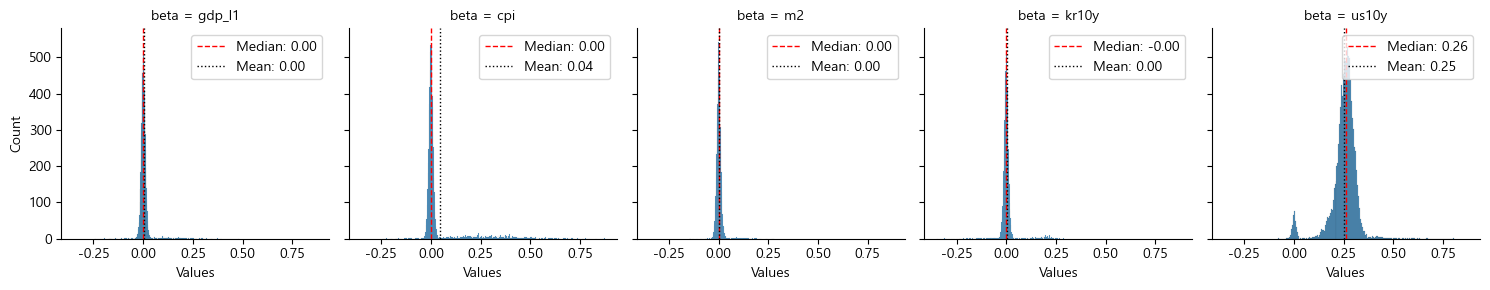

In [17]:
res.plot_hist('beta')

- 사후포함확률(ppi) 그리기

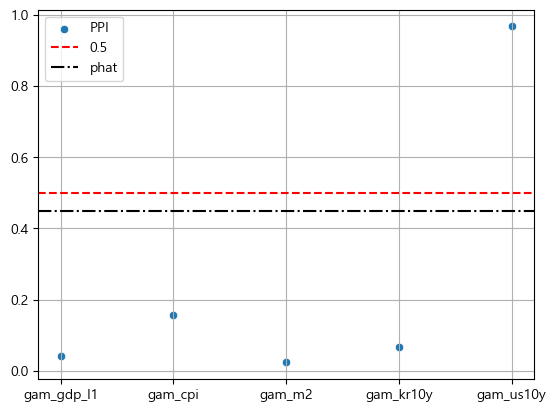

In [18]:
res.plot_ppi()